In [2]:
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import numpy  as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import pickle as pk

In [4]:
raw = pd.read_csv("../Data/traindata_full_dummified.csv")
raw_test = pd.read_csv("../Data/testdata_full_dummified.csv")
print(raw.shape)
print(raw_test.shape)

(1458, 241)
(1459, 240)


In [6]:
def find_outliers(df,col):
    mean = np.mean(df[col], axis=0)
    sd = np.std(df[col], axis=0)
    gap=mean-4*sd
    gap2=mean+4*sd
    outliers = df[ (df[col] > gap2) | (df[col]< gap)].index
    return outliers


In [7]:
miscval=list(find_outliers(raw, 'MiscVal'))
lotarea=list(find_outliers(raw, 'LotArea'))
droplist=miscval+lotarea
raw.drop(droplist,axis=0, inplace=True)

In [8]:
sale_price = raw['LogSalePrice']
raw = raw.drop(['LogSalePrice','Id'],axis=1)
X = raw.copy()
Y = sale_price.copy()
test_IDs = pd.DataFrame(raw_test['Id'])
raw_test = raw_test.drop('Id', axis = 1)

In [9]:
print(raw.shape)
print(X.shape)
print(raw_test.shape)


(1444, 239)
(1444, 239)
(1459, 239)


### Checking for best alpha

In [23]:
ridge = Ridge(normalize=True)

In [24]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.25, random_state= 0)

In [17]:
alphas = np.arange(0,20)
ridge.set_params(normalize=True)
coefs  = []
scores = []
for alpha in alphas:
        ridge.set_params(alpha=alpha)
        ridge.fit(X, Y)  
        coefs.append(ridge.coef_)
        scores.append(ridge.score(X, Y))
coefs = pd.DataFrame(coefs, index = alphas, columns = X.columns)  

Text(0, 0.5, 'slope values')

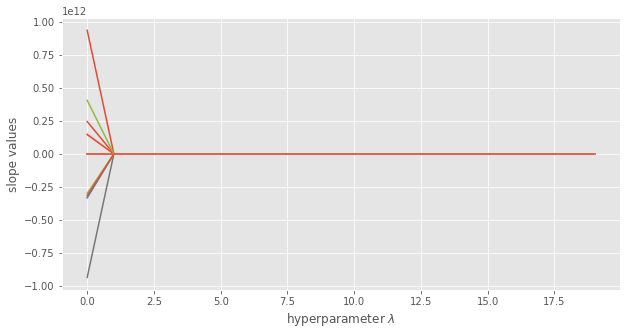

In [20]:
plt.rcParams['figure.figsize'] = (10,5)
for name in coefs.columns:
    plt.plot(coefs.index, coefs[name], label=name)   
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')



In [21]:
alphas = np.arange(0,4)
ridge.set_params(normalize=True)
coefs  = []
scores = []
for alpha in alphas:
        ridge.set_params(alpha=alpha)
        ridge.fit(X, Y)  
        coefs.append(ridge.coef_)
        scores.append(ridge.score(X, Y))
coefs = pd.DataFrame(coefs, index = alphas, columns = X.columns)

Text(0, 0.5, 'slope values')

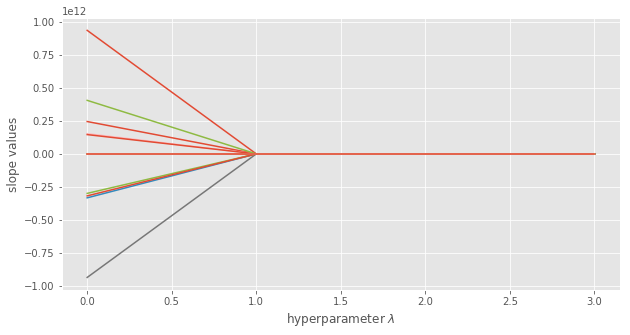

In [22]:
plt.rcParams['figure.figsize'] = (10,5)
for name in coefs.columns:
    plt.plot(coefs.index, coefs[name], label=name)   
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')


### Running model with train test split

In [ ]:
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.25, random_state= 0)

In [41]:
## Running GridsearchCV with Ridge
alphas_ridge = np.linspace(0,2,50)
tuned_parameters_r = [{'alpha': alphas_ridge}]
n_folds = 5
cv = KFold(n_splits=n_folds, shuffle=True)

tune_ridge = GridSearchCV(ridge, tuned_parameters_r, 
                          cv=cv, refit=True, return_train_score = True, 
                          scoring = 'neg_mean_squared_error')
tune_ridge.fit(train_X,train_Y)
print("Tune best score: ",tune_ridge.best_params_)
print("Tune best RMSE: ",sqrt(np.min((-tune_ridge.cv_results_['mean_test_score']))))

Tune best score:  {'alpha': 0.2040816326530612}
Tune best RMSE:  0.12190470534841004


In [42]:
#running ridge with CV alpha 
ridge.set_params(alpha = tune_ridge.best_params_['alpha'], normalize = True)
ridge.fit(train_X, train_Y)
ridge.score(train_X, train_Y)

print("Train/test score",ridge.score(train_X, train_Y))
print("Train/test RMSE", sqrt(mean_squared_error(test_Y, ridge.predict(test_X))))


Train/test score 0.9432410264024194
Train/test RMSE 0.12945630381679116


In [43]:
predict_ridge = pd.DataFrame(np.exp(ridge.predict(raw_test)))
full_pred_r = pd.concat([test_IDs,predict_ridge], axis = 1)
full_pred_r.columns = ['Id', 'SalePrice']
full_pred_r.to_csv('results_ridge_full_new.csv', index = False)


### Running Ridge on full data set

In [44]:
ridge = Ridge( normalize = True)

In [49]:
alphas_ridge = np.linspace(0,2,50)
tuned_parameters = [{'alpha': alphas_lasso}]
n_folds = 6
cv = KFold(n_splits=n_folds, shuffle=True)
tune_ridge = GridSearchCV(ridge, tuned_parameters, 
                          cv=cv, refit=True, return_train_score = True, 
                          scoring = 'neg_mean_squared_error')
tune_ridge.fit(X,Y)
print("Tune best score: ",tune_ridge.best_params_)
print("Tune best RMSE: ",sqrt(np.min(-tune_ridge.cv_results_['mean_test_score'])))

Tune best score:  {'alpha': 0.001}
Tune best RMSE:  0.12380822962304758


In [50]:
ridge.set_params(alpha = tune_ridge.best_params_['alpha'], normalize = True)
ridge.fit(X, Y)
print("Full set score",ridge.score(X, Y))
print("Full set RMSE", sqrt(mean_squared_error(Y, ridge.predict(X))))


Full set score 0.9458312186676455
Full set RMSE 0.09233335990783667


### Running for loop to get best alphas with narrower range train set

In [69]:
tune_scores = []
tune_alphas = []
scores = []
rmse = []

for i in range(10):
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.25, random_state= 0)
    ridge = Ridge(normalize = True)
    ridge_tune_nest = GridSearchCV(ridge, [{'alpha': np.linspace(0,1.5,50)}], 
                          cv=KFold(n_splits=5, shuffle=True), refit=True, return_train_score = True, 
                          scoring = 'neg_mean_squared_error')
    ridge_tune_nest.fit(train_X, train_Y)
    tune_scores.append(np.min(-ridge_tune_nest.cv_results_['mean_test_score']))
    tune_alphas.append(ridge_tune_nest.best_params_['alpha'])
    print("Tune best RMSE: ",sqrt(np.min(-tune_ridge.cv_results_['mean_test_score'])))
    ridge.set_params(alpha = ridge_tune_nest.best_params_['alpha'], normalize = True)
    ridge.fit(train_X, train_Y)
    scores.append(ridge.score(X, Y))
    rmse.append(sqrt(mean_squared_error(Y, ridge.predict(X))))
    print("Full set score",ridge.score(X, Y))
    print("Full set RMSE", sqrt(mean_squared_error(Y, ridge.predict(X))))


Tune best RMSE:  0.12380822962304758
Full set score 0.9310024939545832
Full set RMSE 0.10420793822574739
Tune best RMSE:  0.12380822962304758
Full set score 0.931868426186696
Full set RMSE 0.10355195852825486
Tune best RMSE:  0.12380822962304758
Full set score 0.931868426186696
Full set RMSE 0.10355195852825486
Tune best RMSE:  0.12380822962304758
Full set score 0.9310024939545832
Full set RMSE 0.10420793822574739
Tune best RMSE:  0.12380822962304758
Full set score 0.928389042440335
Full set RMSE 0.10616316250520794
Tune best RMSE:  0.12380822962304758
Full set score 0.9310024939545832
Full set RMSE 0.10420793822574739
Tune best RMSE:  0.12380822962304758
Full set score 0.931868426186696
Full set RMSE 0.10355195852825486
Tune best RMSE:  0.12380822962304758
Full set score 0.9301327498553005
Full set RMSE 0.10486267496556666
Tune best RMSE:  0.12380822962304758
Full set score 0.9335831991435349
Full set RMSE 0.1022405278922016
Tune best RMSE:  0.12380822962304758
Full set score 0.931002

In [70]:
best_rmse,indx = min((v,i) for i,v in enumerate(rmse))
best_alpha = tune_alphas[indx]
print("best alpha:", best_alpha)
print("best rmse:", best_rmse)

best alpha: 0.12244897959183673
best rmse: 0.1022405278922016


### Running for loop to get best alphas with narrower range

In [63]:
tune_scores = []
tune_alphas = []
scores = []
rmse = []

for i in range(10):
    ridge = Ridge(normalize = True)
    ridge_tune_nest = GridSearchCV(ridge, [{'alpha': np.linspace(0,1.5,50)}], 
                          cv=KFold(n_splits=5, shuffle=True), refit=True, return_train_score = True, 
                          scoring = 'neg_mean_squared_error')
    ridge_tune_nest.fit(X, Y)
    tune_scores.append(np.min(-ridge_tune_nest.cv_results_['mean_test_score']))
    tune_alphas.append(ridge_tune_nest.best_params_['alpha'])
    print("Tune best RMSE: ",sqrt(np.min(-tune_ridge.cv_results_['mean_test_score'])))
    ridge.set_params(alpha = ridge_tune_nest.best_params_['alpha'], normalize = True)
    ridge.fit(X, Y)
    scores.append(ridge.score(X, Y))
    rmse.append(sqrt(mean_squared_error(Y, ridge.predict(X))))
    print("Full set score",ridge.score(X, Y))
    print("Full set RMSE", sqrt(mean_squared_error(Y, ridge.predict(X))))


Tune best RMSE:  0.12380822962304758
Full set score 0.9371983226400478
Full set RMSE 0.09941907737055528
Tune best RMSE:  0.12380822962304758
Full set score 0.9371983226400478
Full set RMSE 0.09941907737055528
Tune best RMSE:  0.12380822962304758
Full set score 0.9371983226400478
Full set RMSE 0.09941907737055528
Tune best RMSE:  0.12380822962304758
Full set score 0.9371983226400478
Full set RMSE 0.09941907737055528
Tune best RMSE:  0.12380822962304758
Full set score 0.9395596717125797
Full set RMSE 0.09753208625654512
Tune best RMSE:  0.12380822962304758
Full set score 0.938351613828319
Full set RMSE 0.09850198055870032
Tune best RMSE:  0.12380822962304758
Full set score 0.938351613828319
Full set RMSE 0.09850198055870032
Tune best RMSE:  0.12380822962304758
Full set score 0.938351613828319
Full set RMSE 0.09850198055870032
Tune best RMSE:  0.12380822962304758
Full set score 0.9371983226400478
Full set RMSE 0.09941907737055528
Tune best RMSE:  0.12380822962304758
Full set score 0.9383

In [64]:
best_rmse,indx = min((v,i) for i,v in enumerate(rmse))
best_alpha = tune_alphas[indx]
print("best alpha:", best_alpha)
print("best rmse:", best_rmse)

best alpha: 0.09183673469387754
best rmse: 0.09753208625654512


In [71]:
ridge.set_params(alpha = best_alpha, normalize = True)
ridge.fit(X, Y)

Ridge(alpha=0.12244897959183673, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=True, random_state=None, solver='auto',
   tol=0.001)

###  Saving model 

In [66]:
filename = 'finalized_model_best_ridge.sav'
pk.dump(ridge, open(filename, 'wb'))

### Predicting results and preparing for kaggle submission

In [72]:
predict_ridge = pd.DataFrame(np.exp(ridge.predict(raw_test)))
full_pred = pd.concat([test_IDs,predict_ridge], axis = 1)
full_pred.columns = ['Id', 'SalePrice']
full_pred.to_csv('results_ridge.csv', index = False)